# 一番いいモデル＋被験者実験とかの考察もここ


In [18]:
import numpy as np
import gensim
import requests
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
import pandas as pd
from wikipedia2vec import Wikipedia2Vec
import pickle
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

In [19]:
#dataのインポート+シャッフル
data = pd.read_csv("./1_preprocessed_data.csv",index_col = 0).sample(frac=1, random_state=1).reset_index(drop=True)
print(data.shape)
print(data.columns)

(425, 33)
Index(['Unnamed: 0.1', 'class_a', 'class_b', 'relation', 'ans_yamasaki',
       'ans_ueda', 'ans_daisuke', 'ans_hosomi', 'ans_kazuma', 'ans_sugi',
       'type', 'title', 'source', 'sim_by_mcg', 'is_a_by_mcg', 'lexvec_sim',
       'wiki2vec_sim', 'wn_hu_average', 'wn_pu_average', 'wn_hu_best',
       'wn_pu_best', 'wn_sim_path', 'wn_sim_lch', 'wn_sim_wup', 'wn_sim_res',
       'wn_sim_jcn', 'wn_sim_lin', 'has_same_word', 'is_include_word',
       'bert_sim', 'lexvec_diff', 'wiki2vec_diff', 'bert_diff'],
      dtype='object')


In [20]:
#カラム配列定義
#特徴量カラム
feature_columns =  ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup",
                "is_include_word","bert_sim","lexvec_diff","wiki2vec_diff","bert_diff"]


#通常の特徴量ラベル
X_normal_columns = ["sim_by_mcg","is_a_by_mcg","lexvec_sim","wiki2vec_sim","wn_hu_average",
                "wn_pu_average","wn_sim_path","wn_sim_wup","is_include_word","bert_sim"]

#ベクトル系特徴量ラベル
pca_di={"lexvec_diff":30,"wiki2vec_diff":30,"bert_diff":3}

#被験者実験データ
ans_columns = [ 'ans_ueda',
       'ans_daisuke', 'ans_kazuma', 'ans_sugi','ans_yamasaki','ans_hosomi']

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425 entries, 0 to 424
Data columns (total 33 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Unnamed: 0.1     425 non-null    int64  
 1   class_a          425 non-null    object 
 2   class_b          425 non-null    object 
 3   relation         425 non-null    object 
 4   ans_yamasaki     425 non-null    object 
 5   ans_ueda         425 non-null    object 
 6   ans_daisuke      425 non-null    object 
 7   ans_hosomi       425 non-null    object 
 8   ans_kazuma       425 non-null    object 
 9   ans_sugi         425 non-null    object 
 10  type             425 non-null    object 
 11  title            425 non-null    object 
 12  source           425 non-null    object 
 13  sim_by_mcg       418 non-null    float64
 14  is_a_by_mcg      423 non-null    float64
 15  lexvec_sim       425 non-null    float64
 16  wiki2vec_sim     419 non-null    float64
 17  wn_hu_average   

In [22]:

# 欠損値は最頻値補完を行う
def fill_na_mean(data):
    data.loc[:,"sim_by_mcg"] = data.loc[:,"sim_by_mcg"].fillna(data.loc[:,"sim_by_mcg"].mode()[0])
    data.loc[:,"is_a_by_mcg"] = data.loc[:,"is_a_by_mcg"].fillna(data.loc[:,"is_a_by_mcg"].mode()[0])
    data.loc[:,"wiki2vec_sim"] = data.loc[:,"wiki2vec_sim"].fillna(data.loc[:,"wiki2vec_sim"].mode()[0])
    data.loc[:,"wiki2vec_diff"] = data.loc[:,"wiki2vec_diff"].fillna(data.loc[:,"wiki2vec_diff"].mode()[0])
    return data
data = fill_na_mean(data)
#クラスラベルエンコーディング
from sklearn.preprocessing import LabelEncoder
def label_encorder(data):
    le = LabelEncoder()
    encoded = le.fit_transform(data['relation'].values)
    for ans_c in ans_columns:
        temp_label = le.transform(data[ans_c].values)
        data[ans_c] = temp_label
    data.loc[:,'relation_label'] = encoded
    print(str(data["relation"].unique())+","+str(le.transform(data["relation"].unique())))
    return data
data = label_encorder(data)

['s1' 'h2' 'h1' 's2' 'k'],[3 1 0 4 2]


In [23]:
#特徴量の選別 wn_sim_jcnは値がバグっているので使わない(infinityが入っている)
X_data = data.loc[:,feature_columns]
# yの定義
y = data.loc[:,"relation_label"].values.astype("int32")

In [24]:

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#diffラベルのpca_ssモデル trainとtest arrを返す
def ss_pca(train,pca_n):
    scaler = StandardScaler()
    train=scaler.fit_transform(train)
    pca = PCA(n_components = pca_n)
    train = pca.fit_transform(train)
    return train
#str_arrをarrに変換
def convert_to_arr(vec_str):
    vec_arr = None
    for s in vec_str:
        if vec_arr is None:
            vec_arr =np.array(s[1:-1].split(", ")).astype("float32")
        else:
            vec_arr = np.block([[vec_arr],[np.array(s[1:-1].split(", ")).astype("float32")]])
    return vec_arr

In [25]:


#pca成分の生成
from sklearn.model_selection import StratifiedKFold,LeaveOneOut,KFold
from copy import deepcopy
import xgboost as xgb
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA


skf = StratifiedKFold(n_splits=90,random_state = 0)#80
#cm = None #混合配列
acc = list()#acc配列

y_test_arr = None#testの記録
y_pred_arr = None#predの記録


trans_df =None #検証用に並び替えられたDF

count = 1

for train_idx, test_idx in skf.split(X_data,y):
    print(str(count)+"epoc")
    count += 1
    
    #diff系以外をarrayに入れる 
    X = X_data.loc[:,X_normal_columns].values.astype("float64").astype("float64")
    
    
    # ベクトル系カラムをpcaする
    for column, n in pca_di.items():
        vec_arr = convert_to_arr(X_data.loc[:,column])
        pca_arr = ss_pca(vec_arr,n)
        X = np.concatenate([X, pca_arr], 1)
        
    
    #分割
    X_train = X[train_idx,:]
    X_test = X[test_idx,:]
    y_train = y[train_idx]
    y_test = y[test_idx]
    #print(X_train.shape)
    
    
    #testindexから同時にdfの並び替えも行う。
    temp_df = data.iloc[test_idx,:]
    if trans_df is None:
        trans_df = temp_df
    else:
        trans_df = pd.concat([trans_df,temp_df])
    
    #XGBOOST
    model = xgb.XGBClassifier(n_estimators=300,max_depth=17,learning_rate=0.25)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    
    #結果の保存
    #print(accuracy_score(y_test, y_pred))
    #acc.append(accuracy_score(y_test, y_pred))
    #cm_temp = confusion_matrix(y_pred, y_test)
    if y_test_arr is None:
        #cm = cm_temp
        y_test_arr  = y_test
        y_pred_arr = y_pred
    else:
        #cm = cm + cm_temp
        y_test_arr= np.append(y_test_arr,y_test)
        y_pred_arr= np.append(y_pred_arr,y_pred)
        



/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:293: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  warnings.warn(
/Users/akihito/.pyenv/versions/3.8.5/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 82 members, which is less than n_splits=90.
  warnings.warn(("The least populated class in y has only %d"


1epoc
2epoc
3epoc
4epoc
5epoc
6epoc
7epoc
8epoc
9epoc
10epoc
11epoc
12epoc
13epoc
14epoc
15epoc
16epoc
17epoc
18epoc
19epoc
20epoc
21epoc
22epoc
23epoc
24epoc
25epoc
26epoc
27epoc
28epoc
29epoc
30epoc
31epoc
32epoc
33epoc
34epoc
35epoc
36epoc
37epoc
38epoc
39epoc
40epoc
41epoc
42epoc
43epoc
44epoc
45epoc
46epoc
47epoc
48epoc
49epoc
50epoc
51epoc
52epoc
53epoc
54epoc
55epoc
56epoc
57epoc
58epoc
59epoc
60epoc
61epoc
62epoc
63epoc
64epoc
65epoc
66epoc
67epoc
68epoc
69epoc
70epoc
71epoc
72epoc
73epoc
74epoc
75epoc
76epoc
77epoc
78epoc
79epoc
80epoc
81epoc
82epoc
83epoc
84epoc
85epoc
86epoc
87epoc
88epoc
89epoc
90epoc


0.6494117647058824
              precision    recall  f1-score   support

           0       0.74      0.82      0.78        83
           1       0.75      0.81      0.78        83
           2       0.49      0.51      0.50        95
           3       0.61      0.57      0.59        82
           4       0.66      0.56      0.61        82

    accuracy                           0.65       425
   macro avg       0.65      0.65      0.65       425
weighted avg       0.65      0.65      0.65       425



<AxesSubplot:>

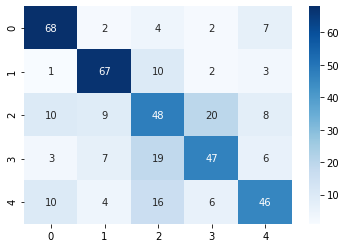

In [26]:
import seaborn as sns
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report
print(accuracy_score(y_test_arr, y_pred_arr))
print(classification_report(y_test_arr,y_pred_arr))
cm = confusion_matrix(y_test_arr, y_pred_arr)
sns.heatmap(cm,annot=True, cmap='Blues')

# ansの考察

<AxesSubplot:>

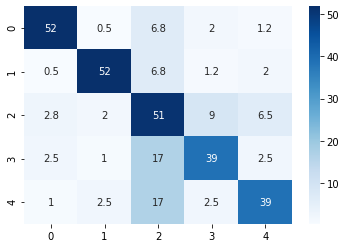

In [27]:
expert_ans_columns = ["ans_ueda","ans_daisuke","ans_sugi"]
#confusion matrix
from sklearn.metrics import confusion_matrix
sum_cm = None
for c in expert_ans_columns:
    ans_arr = trans_df.loc[:,c].values
    cm = confusion_matrix(y_test_arr, ans_arr )
    if sum_cm is None:
        sum_cm = cm
    else:
        sum_cm += cm
sns.heatmap(sum_cm/4,annot=True, cmap='Blues')

In [28]:
#f1配列
from sklearn.metrics import f1_score
f1_list = list()
for c in ans_columns:
    print(c)
    ans_arr = trans_df.loc[:,c].values
    f1_list.append(f1_score(y_test_arr, ans_arr, average="micro")) 
print(f1_list)

ans_ueda
ans_daisuke
ans_kazuma
ans_sugi
ans_yamasaki
ans_hosomi
[0.6941176470588235, 0.7294117647058823, 0.48, 0.76, 0.4000000000000001, 0.4000000000000001]


In [29]:
np.mean(sorted(f1_list,reverse=True)[0:3])

0.727843137254902

In [30]:
print(classification_report(y_test_arr,trans_df["ans_hosomi"]))

              precision    recall  f1-score   support

           0       0.39      0.43      0.41        83
           1       0.38      0.43      0.41        83
           2       0.45      0.61      0.52        95
           3       0.38      0.24      0.30        82
           4       0.34      0.24      0.29        82

    accuracy                           0.40       425
   macro avg       0.39      0.39      0.38       425
weighted avg       0.39      0.40      0.39       425



In [31]:
len(trans_df["source"].unique())

11

In [39]:
trans_df["pred_label"] = y_pred_arr

In [40]:
trans_df.to_csv("3_predicted_data.csv",index=False)